In [2]:
import utils
import plotting
import register
import numpy as np
import scipy.ndimage.measurements as spm

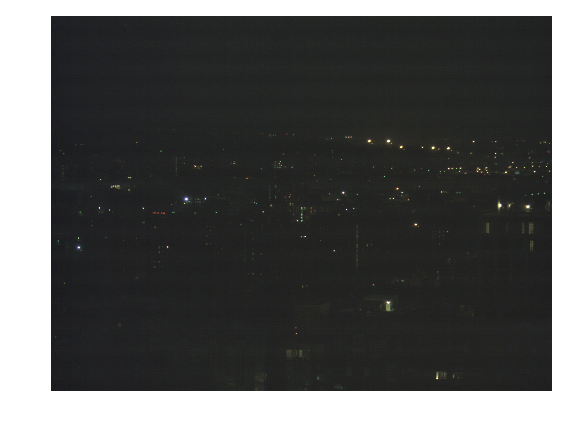

In [3]:
img = utils.read_raw("/green-projects/project-uo_rebound/workspace/share/data/data_full_night_test/test_night_03210_alt.raw", rgb = True)
# img = utils.gamma_scale(utils.stretch_image(img, [3,200]), 1.0, scl=30.0*np.array([1.2,0.8,1.2]))
img = utils.gamma_scale(img)
plotting.plot_image(img)

In [198]:
img.shape

(1536, 2048, 3)

### finding the scaling factor 

In [4]:
# sources in broadband
rr_bb = np.array([513.543, 544.131, 709.32])
cc_bb = np.array([1301.77, 1623.33, 1414.98])

In [5]:
#sources in hyperspectral
rr_hsi = np.array([852.906, 863.483, 931.829])
cc_hsi = np.array([2065.47, 2194.84, 2112.66])

In [20]:
#distance between broadband sources 
dist_bb = np.sqrt((rr_bb[:, np.newaxis] - rr_bb)**2 + 
                (cc_bb[:,np.newaxis] - cc_bb)**2)

bb1 = dist_bb[0,1]
bb2 = dist_bb[0,2]
bb3 = dist_bb[1,2]
print (bb1, bb2, bb3)

(323.0115467657464, 226.15290807106598, 265.88931573306962)


In [21]:
#distance between hyperspectral sources 
dist_hsi = np.sqrt((rr_hsi[:, np.newaxis] - rr_hsi)**2 + 
                (cc_hsi[:,np.newaxis] - cc_hsi)**2)

hsi1 = dist_hsi[0, 1]
hsi2 = dist_hsi[0, 2]
hsi3 = dist_hsi[1, 2]
print (hsi1, hsi2, hsi3)

(129.80165572518746, 91.955076145909445, 106.88651980488488)


In [22]:
factor = ((bb1/hsi1) + (bb2/hsi2) + (bb3/hsi3)) / 3
factor

2.4784902659724479

In [23]:


# -- get average intensity of pixels across rgb channels
img_a = img.mean(-1)

# -- get medians and standard deviations of luminosity images
med = np.median(img_a)
sig = img_a.std()

# -- get the thresholded images
thr = img_a > (med + 4.0*sig)


In [24]:
# -- label the sources
labs = spm.label(thr)

# -- get the source sizes
lsz = spm.sum(thr, labs[0], range(1, labs[1]+1))

In [25]:
# -- get the positions of the sources
ind = (lsz > 2.) & (lsz < 1700.) 

# -- get center of masses for all the labelled sources in the image
rr1, cc1, = np.array(spm.center_of_mass(thr, labs[0], 
                                   np.arange(1, labs[1]+1)[ind])).T

In [26]:
#Extract the center of masses of sources above the threshold
# rr1, cc1 = register.locate_sources(img)
# rr1.shape

In [27]:
print rr1.shape
print cc1.shape

(321,)
(321,)


In [28]:
#Calculating distances between sources of image
dist = np.sqrt((rr1[:, np.newaxis] - rr1)**2 + (cc1[:,np.newaxis] - cc1)**2)
print dist.shape

(321, 321)


In [29]:
dist = (dist / factor)
print dist

[[   0.           10.88853107   19.77745502 ...,  405.6806696   426.25630932
   425.21538526]
 [  10.88853107    0.            8.91804707 ...,  403.18548857
   426.41573572  425.12896055]
 [  19.77745502    8.91804707    0.         ...,  402.31236046
   427.71984453  426.23445664]
 ..., 
 [ 405.6806696   403.18548857  402.31236046 ...,    0.          104.16056453
    94.69278932]
 [ 426.25630932  426.41573572  427.71984453 ...,  104.16056453    0.
     9.68331421]
 [ 425.21538526  425.12896055  426.23445664 ...,   94.69278932
     9.68331421    0.        ]]


In [30]:
def find(dist, dcat, buff=10):
    """
    Find potential sources ith the appropriate distance  ratios
    """
    
    # -- 
    src = np.arange(dist.shape[0])
    dcat   = dcat[dcat>0]
    for tdist in dcat:
        tind  = (np.abs(dist - tdist) < buff).any(1)
        dist = dist[tind]
        src = src[tind]
        if tdist == dcat[-1]:
            return src

def find_quads(dist, rr_cat, cc_cat):
    """
    Find quads of sources with the appropriate distance ratios.
    """

    # -- trim rows that do not have that distance distribution
    pts  = []

    # -- get all possible points
    allind = np.arange(dist.shape[0])
    
    dcat0 = np.sqrt(((rr_cat[0] - rr_cat)**2 + (cc_cat[0] - cc_cat)**2))
    dcat1 = np.sqrt(((rr_cat[1] - rr_cat)**2 + (cc_cat[1] - cc_cat)**2))
    dcat2 = np.sqrt(((rr_cat[2] - rr_cat)**2 + (cc_cat[2] - cc_cat)**2))
    
    p0ind = find(dist, dcat0)
    p1ind = find(dist, dcat1)
    p2ind = find(dist, dcat2)
    
    return p0ind, p1ind, p2ind
    

In [31]:
p0ind, p1ind, p2ind = find_quads(dist, rr_hsi, cc_hsi)
print p0ind
print p1ind
print p2ind

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [42]:
dcat0 = np.sqrt(((rr_hsi[0] - rr_hsi)**2 + (cc_hsi[0] - cc_hsi)**2))
dcat1 = np.sqrt(((rr_hsi[1] - rr_hsi)**2 + (cc_hsi[1] - cc_hsi)**2))
dcat2 = np.sqrt(((rr_hsi[2] - rr_hsi)**2 + (cc_hsi[2] - cc_hsi)**2))
good01 = []
for ii in p0ind:
    for jj in p1ind:
        if np.abs((dist[ii,jj] /factor) - dcat0[1]) < 10:
            good01.append([ii, jj])
good012 = []
for ii,jj in good01:
    for kk in p2ind:
        flag02 = np.abs((dist[ii, kk] / factor) - dcat0[2]) < 10
        flag12 = np.abs((dist[jj, kk] / factor) - dcat1[2]) < 10
        if flag02 and flag12:
            good012.append([ii, jj, kk])



In [43]:
good012 = np.array(good012)
# good012 = good012[(cc1[good012[:, 0]] - cc1[good012[:, 1]]) > 100]

In [44]:
good012

array([[  0,  14, 269],
       [  0,  14, 278],
       [  0,  14, 282],
       ..., 
       [319, 301, 271],
       [319, 301, 281],
       [319, 301, 297]])

In [45]:
p0s, p1s, p2s = np.array(good012).T

# -- find the delta angles of the first 2 pairs
theta01 = np.arccos((rr1[p0s] - rr1[p1s]) / dist[p0s, p1s])
theta02 = np.arccos((rr1[p0s] - rr1[p2s]) / dist[p0s, p2s])
dtheta  = (theta01 - theta02) * 180. / np.pi

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in arccos
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in arccos


In [46]:
dcatm = np.sqrt((rr_hsi[:, np.newaxis] - rr_hsi)**2 + 
                (cc_hsi[:,np.newaxis] - cc_hsi)**2)

In [47]:
dcatm

array([[   0.        ,  129.80165573,   91.95507615],
       [ 129.80165573,    0.        ,  106.8865198 ],
       [  91.95507615,  106.8865198 ,    0.        ]])

In [48]:
# -- find the delta angle of thr first 2 sources of catalog
theta01_cat = np.arccos((rr_hsi[0] - rr_hsi[1]) / dcatm[0, 1])
theta02_cat = np.arccos((rr_hsi[0] - rr_hsi[2]) / dcatm[0, 2])
dtheta_cat  = (theta01_cat - theta02_cat) * 180. / np.pi

In [49]:
guess = np.array(good012[np.abs(dtheta - dtheta_cat).argmin()])
print guess

[  0  14 269]


In [50]:
rrr0, ccc0 = rr_hsi[np.array([0, 1, 2])], cc_hsi[np.array([0, 1, 2])]
rrr1, ccc1 = rr1[guess], cc1[guess]

In [51]:
print rrr1
print ccc1

[ 486.          516.53030303  897.54545455]
[  963.42857143  1727.25757576  1251.72727273]


In [27]:
# -- get positions of image sources and catalog sources to know the quadrant they occupy
roff  = img.shape[0] // 2
coff  = img.shape[1] // 2
rrr0 -= roff
rrr1 -= roff
ccc0 -= coff
ccc1 -= coff

# -- get the matrix for catalog sources
mones      = np.zeros(rrr0.size*2+1)
mones[::2] = 1.0

pm         = np.zeros([rrr0.size*2,4])
pm[::2,0]  = rrr0
pm[1::2,0] = ccc0
pm[::2,1]  = -ccc0
pm[1::2,1] = rrr0
pm[:,2]    = mones[:-1]
pm[:,3]    = mones[1:]

# -- get the matrix for image sources
bv         = np.zeros([rrr0.size*2])
bv[::2]    = rrr1
bv[1::2]   = ccc1

# -- calculating rotation of image 
pmTpm = np.dot(pm.T, pm)
av    = np.dot(np.linalg.inv(pmTpm), np.dot(pm.T, bv))

dr, dc = av[-2:]
dtheta = np.arctan2(av[1],av[0]) * 180. / np.pi

In [28]:
print (dr, dc, dtheta)

(-577.0839931421433, -6209.7248777535133, 1.9442478100146934)
